# Dynamic Model Averaging (DMA) Application for Germany
This notebook is supposed to bundle the parts for DMA application to Germany and produce the analysis used in the final paper.
It is structured as follows:
1. Present Data
2. Present Factor Analysis results
3. Find optimal parameters
4. Run DMA on the baseline model specifications
5. Show DMA Output
   1. Inclusion Probabilities
   2. Expected number of predictors
   3. Forecast performance
6. Interaction between DMA and Factor analysis
   1. Without F.A.
   2. Different lag/ factor combinations
   3. DMA on best factors

In [1]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import itertools
import random
import plotly
import plotly.express as px
import scipy.stats as stats
import matplotlib.pyplot as plt
from factor_analyzer.factor_analyzer import FactorAnalyzer
from statsmodels.regression.linear_model import OLS

from src.data import import_data
from src.data.data_class import Data
from src.models.preliminaries import Settings
from src.models.dma import DMA
from src.models.tvp import TVP
from src.models import dm_test


from helper_scripts import variable_groups

from statsmodels.tsa import seasonal

# Replication Settings

In [2]:
# specify which parts of the analysis to replicate
    # if the pickle files of the DMA results are not available, loading is not possible
    # as the analysis takes quite some time, it might be relevant to save results as it shortens the execution time when running the code again
replicate = {'plot_data': False,         # replicate exploratory data analysis
            'factor_analysis': True,       # produce FA results or simply load the resulting df
                'plot_fa_stats': True,
             'grid_search': False,      # first grid search to get an idea which are the best combinations
                'save_grid_results': False,
             'DMA_FA_selected': False,   # DMA with data from factor analysis on selected combinations
                'save_DMA_FA': False,    # save results
             'other_models': True,  # tvp and ar model
                'save_other_models': False,
            'preferred_models_analysis': True,
             'DMA_FA_interaction': True
                }
output_path = os.path.join(Path().cwd(), 'saved_outputs')
plotly.io.templates.default = "plotly_white"
plotly.io.renderers.default = 'png'

# Data
To recreate the dataset, run the following scripts in src.data:
1. "download_data.py": downloads data from the OECD database
2. "prepare_data.py": runs multiple steps to make the dataset ready for use
   1. transforms vintage data set into growth series (the transformation into growth series circumvents baseline and other changes in the methodology)
   2. combine dataset into one dataset that can be accessed as "data/processed/combined_data.csv"
   3. selects data specified in "data/processed/selected_data.csv"
   4. seasonally transforms the data (Season-Trend decomposition using LOESS - https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.STL.html#statsmodels.tsa.seasonal.STL)

In [3]:
data_path = os.path.join(Path().cwd().parent, 'data', 'processed')
# load seasonally adjusted dataset
with open(os.path.join(data_path, 'df_sa.pkl'), 'rb') as f:
    df_sa = pickle.load(f) # load raw data
# "selected_data.csv" contains information about variables names, abbreviations and the required type of transformation
selection = pd.read_csv(os.path.join(data_path, 'selected_data.csv'))
df_sa.describe()

var code,CPI_house_energy,PCI_energy_,HICP_energy,HICP_excl_energy,CPI,deflator_GDP,unemp,employment,GDP,cons_private,...,interest_rate_long,M3,M1,business_conf_manufacturing,business_conf_construct,business_conf_service,business_conf_retail,cons_conf_tendency,business_situation,residential_permits
count,123.000000,108.000000,104.000000,108.000000,123.000000,123.000000,123.000000,122.000000,123.000000,123.000000,...,123.000000,123.000000,123.000000,123.000000,123.000000,107.000000,123.000000,123.000000,123.000000,111.000000
mean,86.044251,87.012686,84.341505,92.755311,0.004721,0.004284,-0.003422,0.001091,0.002326,0.001503,...,3.463803,73.059570,65.051820,-6.727642,-21.869919,16.915888,-15.618699,99.946968,99.928214,29339.023758
std,14.225694,20.686686,20.142079,8.294870,0.004461,0.004434,0.033366,0.004588,0.011852,0.012954,...,2.511013,32.274109,43.145580,13.369695,20.970658,15.694436,10.782244,1.088837,1.342361,12214.439550
min,54.290421,54.877066,50.172049,79.809765,-0.006218,-0.004797,-0.096044,-0.010906,-0.078606,-0.092427,...,-0.604967,28.239989,16.992672,-42.200000,-55.700000,-22.000000,-41.200000,96.952924,95.408918,12903.224314
25%,73.991181,66.273204,65.311428,85.461263,0.002036,0.001382,-0.023105,-0.001753,-0.000176,-0.001626,...,1.381471,41.848292,27.878798,-15.400000,-42.450000,9.850000,-24.200000,99.334636,99.292014,20146.329471
50%,86.943304,93.195680,90.987561,91.996135,0.004041,0.003839,-0.006730,0.000564,0.003102,0.002517,...,3.829682,70.994604,56.696744,-6.100000,-23.000000,16.500000,-17.800000,99.964845,99.990484,25712.133386
75%,99.834497,103.481214,101.972046,99.628004,0.006383,0.005843,0.019722,0.003528,0.005931,0.005418,...,5.147533,93.580208,87.016878,0.800000,-7.150000,22.550000,-6.400000,100.702736,100.968382,37431.426816
max,109.463789,148.621775,115.784535,109.938300,0.019812,0.021539,0.101676,0.016532,0.047462,0.050932,...,8.387854,145.809700,178.189434,25.600000,20.900000,50.100000,13.500000,102.119658,102.336481,64217.291026


## Exploratory Data Analysis
Plot the data to get an overview over the data and its properties.

In [4]:
# load data with all variables and
params = Settings()                                 # init settings
params.h_fore = 1
params.miss_treatment = 3                           # no treatment for missing variables
params.plag = 4                                     # lag inflation to include later
params.use_x = selection['var code'].to_list()      # specify to use all variables
params.tcodesX = params.get_tcodesX(selection)      # get transformation codes
params.restricted_vars = ['intercept', 'CPI']       # these variables are in all models
params.first_sample_ends = '2004-12-31'             # start of calculation of statistics
# params.print_setting_options()                    # if parameter options should be shown
data = Data(df_sa, params)                          # creates an instance of the Data class that contains the transformed data
df_intercept_CPI = data.X.iloc[:,:(params.plag+params.intercept+1)] # the intercept and annualized CPI+lags are ordered at the beginning of the df - save df to attach it again later
df_sa_trans = data.X.iloc[:,(params.plag+params.intercept+1):]      # remove the vars

%run helper_scripts/variable_groups                 # get variable groups

In [5]:
if replicate['plot_data']:
    if not replicate['load_plots']:
        for g in var_groups:                                # plot variable groups
            df_temp = df_sa_trans[var_groups[g]]
            v_inds = [np.where(selection['var code'] == v)[0][0] for v in var_groups[g]]
            names = [selection['var code'][v]+': '+selection['Variable'][v] for v in v_inds]
            df_temp.columns = names
            fig = px.line(df_temp)
            fig.update_layout(
                        title=str(g),
                        title_x=0.5,
                        yaxis_title='',
                        xaxis_title='',
                        legend_title='Variables',
                        legend_orientation='v',
                        legend_y=0.95
                        )
            fig.show()

# Factor Analysis
Run the Factor analysis to reduce the dimensionality of the data without loosing too much information.

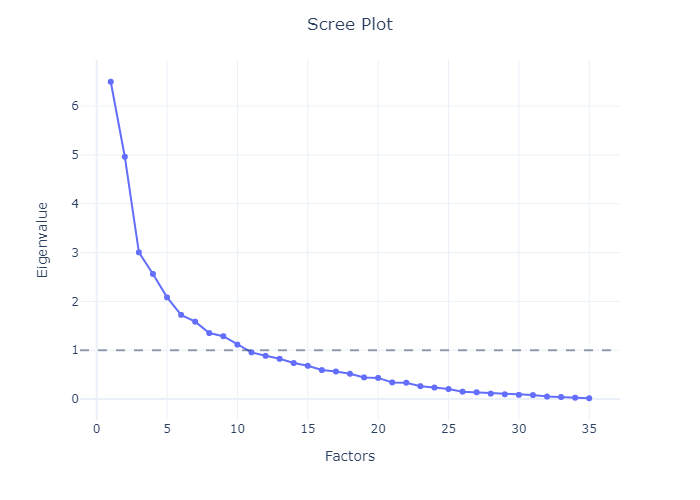

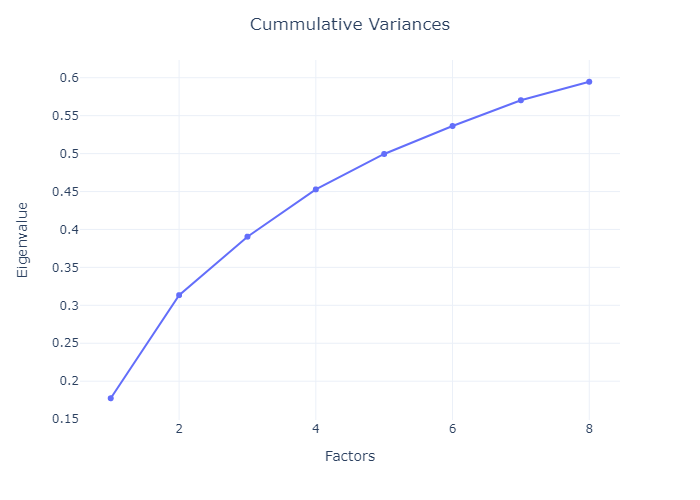

In [6]:
if replicate['factor_analysis']:
    fa_lags = 1
    # Instantiate factor analysis object
    df_fa = df_sa_trans.drop(infl_vars, axis=1)
    n_factors = 8
    fa = FactorAnalyzer(n_factors=n_factors, rotation='oblimax')    # quartimax for orthogonal rotation, oblimax for oblique
    fa.fit(df_fa)
    ev, v = fa.get_eigenvalues()

    # plots
    if replicate['plot_fa_stats']:
        # Scree Plot
        fig = px.line(y=ev, x=range(1,df_fa.shape[1]+1), markers=True)
        fig.add_hline(y=1, line_dash='dash', opacity=0.5)
        fig.update_layout(
                        title='Scree Plot',
                        title_x=0.5,
                        yaxis_title='Eigenvalue',
                        xaxis_title='Factors'
                        )
        fig.show()
        # Cummulative Variances
        fa_var = fa.get_factor_variance()   # returns list with variance, proportional_variance and cumulative_variances
        fig = px.line(y=fa_var[2], x=range(1,n_factors+1), markers=True)
        fig.update_layout(
                        title='Cummulative Variances',
                        title_x=0.5,
                        yaxis_title='Eigenvalue',
                        xaxis_title='Factors'
                        )
        fig.show()

    # Analysis
    # calculate communalities
        # Note: for oblique rotation, the interpretation is different!
    pd_communalities = pd.Series(fa.get_communalities(), index=df_fa.columns, name='Communality')
    #print(pd_communalities)
    # get factors
    df_factors = pd.DataFrame(fa.transform(df_fa.fillna(0)), index = df_fa.index)
    # rename columns
    factor_cols = ['Factor_'+str(i) for i in list(df_factors.columns)]
    df_factors.columns = factor_cols
    # to see whether one should take the oblique rotation, one can look at the correlations in the factors. If they are heavily correlated, use the oblique rotation
    # df_factors.corr()

    # lag factors - This needs to be adjusted if you want more lags
        # The maximum that my PC is able to do with 5 factors is 2 lags
    if fa_lags == 2:
        df_factors_with_lag = pd.concat((df_factors, df_factors.shift(1), df_factors.shift(2)), axis=1)
        factor_cols_lag1 = [i+'_t-1' for i in factor_cols]
        factor_cols_lag2 = [i+'_t-2' for i in factor_cols]
        df_factors_with_lag.columns = factor_cols+factor_cols_lag1+factor_cols_lag2
        df_fa_post = pd.concat((df_intercept_CPI, df_factors_with_lag), axis=1)
        df_fa_post = df_fa_post.iloc[2:, :]
    elif fa_lags == 1:
        df_factors_with_lag = pd.concat((df_factors, df_factors.shift(1)), axis=1)
        factor_cols_lag1 = [i+'_t-1' for i in factor_cols]
        df_factors_with_lag.columns = factor_cols+factor_cols_lag1
        df_fa_post = pd.concat((df_intercept_CPI, df_factors_with_lag), axis=1)
        df_fa_post = df_fa_post.iloc[2:, :]     # account for the lagging of the factors
    # with open(os.path.join(output_path, 'df_fa_quartimax.pkl'), 'wb') as f:
    #     pickle.dump(df_fa_post, f)
else:
    with open(os.path.join(output_path, 'df_fa_quartimax_f8.pkl'), 'rb') as f:
        df_fa_post = pickle.load(f)
# adjust data class for FA results
data.X = df_fa_post # can be deleted from here
data.T = data.X.shape[0]
data.N = data.X.shape[1]
data.y_dep = data.y_dep[2:] # adjust for lagging

In [7]:
# print(df_factors.corr().round(2).to_latex())

In [8]:
pd_communalities

CPI_house_energy               0.637093
PCI_energy_                    0.620122
HICP_energy                    0.568205
unemp                          0.575906
employment                     0.443326
GDP                            0.898026
cons_private                   0.593132
cons_gov                       0.187928
invest                         0.945864
earnings_hourly                0.273226
prod_ind                       0.607375
retail                         0.176934
prod_constr                    0.537696
trade_imp                      0.525979
trade_exp                      0.637714
infl_exp_current_year          0.812245
infl_exp_next_year             0.972426
infl_exp_2_year_ahead          0.970685
infl_exp_5_year_ahead          0.742141
dax                            0.359867
invest_private_no_housing      0.817282
invest_private_housing         0.739999
supply_index_global            0.234917
supply_index_eu                0.293107
interest_rate_short            0.784394


In [9]:
def get_r_quared_factors(factor, df_factors):
    rsquared = {}
    df_temp = pd.concat((factor, df_fa), axis=1).dropna()
    for name, values in df_temp.iloc[:,1:].iteritems():
        model = OLS(endog=df_temp.iloc[:,0], exog=values).fit()
        rsquared[name] = model.rsquared
    return pd.Series(rsquared, name=factor.name)

                # pred = ar_model.predict(X_test_lag)

In [10]:
pd_factor_rsqaured = pd.DataFrame(columns=df_factors.columns)
for name, values in df_factors.iteritems():
    pd_factor_rsqaured[name] = get_r_quared_factors(values, df_fa.iloc[2:, :])
# pd_factor_rsqaured
pd_factor_rsqaured_top = pd.DataFrame()
for name, values in pd_factor_rsqaured.iteritems():
    top5 = values.sort_values(ascending=False)[:5]
    pd_factor_rsqaured_top[name+'_vars'] = top5.index
    pd_factor_rsqaured_top[name+'_R2'] = top5.values
pd_factor_rsqaured_top

,Factor_0_vars,Factor_0_R2,Factor_1_vars,Factor_1_R2,Factor_2_vars,Factor_2_R2,Factor_3_vars,Factor_3_R2,Factor_4_vars,Factor_4_R2,Factor_5_vars,Factor_5_R2,Factor_6_vars,Factor_6_R2,Factor_7_vars,Factor_7_R2
0,invest,0.642667,PCI_energy_,0.372233,business_situation,0.328571,HICP_energy,0.358564,invest,0.359847,M3,0.173657,business_conf_retail,0.228104,retail,0.103644
1,GDP,0.620009,CPI_house_energy,0.305010,employment,0.213790,PCI_energy_,0.348097,prod_constr,0.351621,business_conf_retail,0.162112,infl_exp_2_year_ahead,0.208961,dax,0.094006
2,invest_private_no_housing,0.554766,interest_rate_short,0.280596,unemp,0.171761,invest_private_housing,0.175286,invest_private_housing,0.349100,business_conf_construct,0.148630,infl_exp_next_year,0.200247,infl_exp_current_year,0.072364
3,prod_ind,0.490629,HICP_energy,0.196817,invest_private_housing,0.159341,business_conf_manufacturing,0.168219,supply_index_eu,0.274639,interest_rate_short,0.129923,business_conf_construct,0.196808,unemp,0.069658
4,business_conf_manufacturing,0.385117,infl_exp_current_year,0.175518,trade_exp,0.158893,trade_imp,0.151135,business_situation,0.128845,PCI_energy_,0.080837,infl_exp_5_year_ahead,0.194493,invest,0.065498


In [11]:
# print(pd_factor_rsqaured_top.to_latex())

# Grid Search
Find optimal parameter settings for DMA by doing a grid search over the parameters $\lambda$ and  $\kappa$.

In [12]:
# specify settings for DMA
params.use_y = ['CPI']

# params.print_settings()   # execute this see the current specifications of DMA
# params.print_setting_options()    # execute this see explanations and other available options

In [13]:
def grid_search_a_l(params, data, grid):
    stats_fe = ['alpha', 'lambda', 'MAFE_DMA', 'MSFE_DMA', 'BIAS_DMA', 'MAFE_DMS', 'MSFE_DMS', 'BIAS_DMS']
    pd_stats = pd.DataFrame(columns=stats_fe)
    for g in grid:
        a = g[0]
        l = g[1]
        print(f'run dma for alpha = {a} and lambda = {l}')
        params.alpha = a
        params.lamda = l
        dma = DMA(params, data)
        dma.run_dma()
        dma.forecast_statistics(plot_fe=False, plot_y_fe=False, print_stats=False, unit='percent')
        stats_temp = [a, l, dma.MAFE_DMA, dma.MSFE_DMA, dma.BIAS_DMA, dma.MAFE_DMS, dma.MSFE_DMS, dma.BIAS_DMS]
        pd_stats.loc[str(g)] = stats_temp
    return pd_stats

In [14]:
if replicate['grid_search']:
    # do grid search on data with 4 factors to speed it up
    with open(os.path.join(output_path, 'df_fa_post_4_factors.pkl'), 'rb') as f:
        df_fa_post_4_factors = pickle.load(f)
    alpha_range = np.arange(0.93, 0.991, 0.02)
    lambdaa_range = np.arange(0.93, 0.991, 0.02)
    grid = np.transpose([np.tile(alpha_range, len(lambdaa_range)), np.repeat(lambdaa_range, len(alpha_range))])

    params.h_fore = 1
    data_fa_post_4_factors_h1 = Data(df_sa, params)
    data_fa_post_4_factors_h1.X = df_fa_post_4_factors
    data_fa_post_4_factors_h1.T = data_fa_post_4_factors_h1.X.shape[0]
    data_fa_post_4_factors_h1.N = data_fa_post_4_factors_h1.X.shape[1]
    data_h1 = Data(df_sa, params)
    data_fa_post_4_factors_h1.y_dep = data_h1.y_dep[2:]    # adjust for lagging
    params.h_fore = 4
    data_fa_post_4_factors_h4 = Data(df_sa, params)
    data_fa_post_4_factors_h4.X = df_fa_post_4_factors
    data_fa_post_4_factors_h4.T = data_fa_post_4_factors_h4.X.shape[0]
    data_fa_post_4_factors_h4.N = data_fa_post_4_factors_h4.X.shape[1]
    data_h4 = Data(df_sa, params)
    data_fa_post_4_factors_h4.y_dep = data_h4.y_dep[2:]    # adjust for lagging

    pd_stats_1 = grid_search_a_l(params, data_fa_post_4_factors_h1, grid)
    pd_stats_4 = grid_search_a_l(params, data_fa_post_4_factors_h4, grid)
    if replicate['save_grid_results']:
        with open(os.path.join(output_path, 'pd_stats_1.pkl'), 'wb') as f:
            pickle.dump(pd_stats_1, f)
        with open(os.path.join(output_path, 'pd_stats_4.pkl'), 'wb') as f:
            pickle.dump(pd_stats_4, f)
else:   # the saved results are produced using a dataset produced by factor analysis with the quartimax rotation, 4 factors and two lags of those factors
    with open(os.path.join(output_path, 'pd_stats_1.pkl'), 'rb') as f:
        pd_stats_1 = pickle.load(f)
    with open(os.path.join(output_path, 'pd_stats_4.pkl'), 'rb') as f:
        pd_stats_4 = pickle.load(f)

In [15]:
# results for forecast horizon: 1 quarter
pd_stats_1

,alpha,lambda,MAFE_DMA,MSFE_DMA,BIAS_DMA,MAFE_DMS,MSFE_DMS,BIAS_DMS
[0.93 0.93],0.93,0.93,0.009623,0.000236,0.000829,0.009653,0.000210,0.001037
[0.95 0.93],0.95,0.93,0.009620,0.000231,0.000900,0.009658,0.000232,0.001142
[0.97 0.93],0.97,0.93,0.009593,0.000224,0.000894,0.009624,0.000227,0.000841
[0.99 0.93],0.99,0.93,0.009540,0.000215,0.000761,0.009527,0.000213,0.000744
[0.93 0.95],0.93,0.95,0.009472,0.000225,0.000633,0.009495,0.000219,0.000885
[0.95 0.95],0.95,0.95,0.009429,0.000218,0.000692,0.009288,0.000212,0.000926
[0.97 0.95],0.97,0.95,0.009323,0.000210,0.000690,0.009279,0.000213,0.000730
[0.99 0.95],0.99,0.95,0.009209,0.000203,0.000647,0.009189,0.000201,0.000640
[0.93 0.97],0.93,0.97,0.009239,0.000216,0.000493,0.008933,0.000197,0.000793
[0.95 0.97],0.95,0.97,0.009121,0.000209,0.000549,0.008911,0.000196,0.000713


In [16]:
# results for forecast horizon: 4 quarters
pd_stats_4

,alpha,lambda,MAFE_DMA,MSFE_DMA,BIAS_DMA,MAFE_DMS,MSFE_DMS,BIAS_DMS
[0.93 0.93],0.93,0.93,0.006606,0.000102,0.000341,0.006533,0.000102,0.000435
[0.95 0.93],0.95,0.93,0.006424,0.000098,0.000441,0.006221,0.000095,0.000864
[0.97 0.93],0.97,0.93,0.006239,0.000094,0.000432,0.006393,0.000102,0.000727
[0.99 0.93],0.99,0.93,0.006270,0.000091,0.000341,0.006270,0.000090,0.000328
[0.93 0.95],0.93,0.95,0.006521,0.000099,0.000268,0.006188,0.000089,0.000232
[0.95 0.95],0.95,0.95,0.006300,0.000095,0.000359,0.005986,0.000083,0.000463
[0.97 0.95],0.97,0.95,0.006103,0.000091,0.000358,0.006202,0.000094,0.000579
[0.99 0.95],0.99,0.95,0.006116,0.000087,0.000315,0.006116,0.000086,0.000311
[0.93 0.97],0.93,0.97,0.006450,0.000098,0.000221,0.005984,0.000086,0.000272
[0.95 0.97],0.95,0.97,0.006240,0.000093,0.000305,0.005916,0.000083,0.000443


# DMA on different specifications
Specifications to test:
1. DMA with F.A. reduced dataset and different $\alpha$ and $\lambda$ combinations
2. DMA with some standard predictors
For
- ($\alpha$, $\lambda$) = (0.99, 0.99)
- ($\alpha$, $\lambda$) = (0.97, 0.99)
- ($\alpha$, $\lambda$) = (0.97, 0.97)
- ($\alpha$, $\lambda$) = (0.95, 0.95)
3. Simple TVP model
4. Simple AR model

Do everything for h = 1 and h = 4

In [17]:
def DMA_steps(params, data, alpha, lamda, save, name, output_path):
    params.alpha = alpha
    params.lamda = lamda
    print(f'(alpha, lambda) = ({alpha}, {lamda})')
    dma = DMA(params, data)
    dma.run_dma()
    dma.forecast_statistics(unit='percent', plot_fe=False, plot_y_fe=False, print_stats=False)
    stats_temp = [params.alpha, params.lamda,
                     dma.MAFE_DMA, dma.MSFE_DMA, dma.BIAS_DMA,
                     dma.MAFE_DMS, dma.MSFE_DMS, dma.BIAS_DMS]
    if save:
        with open(os.path.join(output_path, name+'.pkl'), 'wb') as f:
                pickle.dump(dma, f)
    return dma, stats_temp
def get_stats(dma):
    dma.forecast_statistics(unit='percent', plot_fe=False, plot_y_fe=False, print_stats=False)
    stats_temp = [params.alpha, params.lamda,
                     dma.MAFE_DMA, dma.MSFE_DMA, dma.BIAS_DMA,
                     dma.MAFE_DMS, dma.MSFE_DMS, dma.BIAS_DMS]
    return stats_temp

## DMA with Factor Analysis data

In [18]:
# adjust data class for FA results

params.h_fore = 1
data_fa_h1 = Data(df_sa, params)
data_fa_h1.X = df_fa_post
data_fa_h1.T = data.X.shape[0]
data_fa_h1.N = data.X.shape[1]
data_h1 = Data(df_sa, params)
data_fa_h1.y_dep = data_h1.y_dep[2:]    # adjust for lagging
params.h_fore = 4
data_fa_h4 = Data(df_sa, params)
data_fa_h4.X = df_fa_post
data_fa_h4.T = data.X.shape[0]
data_fa_h4.N = data.X.shape[1]
data_h4 = Data(df_sa, params)
data_fa_h4.y_dep = data_h4.y_dep[2:]    # adjust for lagging

stats_fe = ['alpha', 'lambda', 'MAFE_DMA', 'MSFE_DMA', 'BIAS_DMA', 'MAFE_DMS', 'MSFE_DMS', 'BIAS_DMS']

In [19]:
if replicate['DMA_FA_selected']:
    save = replicate['save_DMA_FA']
    params.h_fore=1
    data = data_fa_h1
    # (0.99, 0.99)
    dma_fa_h1_1, stats_fa_h1_1 = DMA_steps(params, data, 0.99, 0.99, save, 'dma_fa_h1_1', output_path)
    # (0.99, 0.97)
    dma_fa_h1_2, stats_fa_h1_2 = DMA_steps(params, data, 0.97, 0.97, save, 'dma_fa_h1_2', output_path)
    # (0.97, 0.97)
    dma_fa_h1_3, stats_fa_h1_3 = DMA_steps(params, data, 0.95, 0.95, save, 'dma_fa_h1_3', output_path)
    # (0.97, 0.95)
    # dma_fa_h1_4, stats_fa_h1_4 = DMA_steps(params, data, 0.93, 0.97, save, 'dma_fa_h1_4', output_path)
else:
    with open(os.path.join(output_path, 'dma_fa_h1_1.pkl'), 'rb') as f:
        dma_fa_h1_1 = pickle.load(f)
    stats_fa_h1_1 = get_stats(dma_fa_h1_1)
    with open(os.path.join(output_path, 'dma_fa_h1_2.pkl'), 'rb') as f:
        dma_fa_h1_2 = pickle.load(f)
    stats_fa_h1_2 = get_stats(dma_fa_h1_2)
    with open(os.path.join(output_path, 'dma_fa_h1_3.pkl'), 'rb') as f:
        dma_fa_h1_3 = pickle.load(f)
    stats_fa_h1_3 = get_stats(dma_fa_h1_3)
    # with open(os.path.join(output_path, 'dma_fa_h1_4.pkl'), 'rb') as f:
    #     dma_fa_h1_4 = pickle.load(f)
    # stats_fa_h1_4 = get_stats(dma_fa_h1_4)

In [20]:
if replicate['DMA_FA_selected']:
    save = replicate['save_DMA_FA']
    params.h_fore=4
    data = data_fa_h4
    # (0.99, 0.99)
    dma_fa_h4_1, stats_fa_h4_1 = DMA_steps(params, data, 0.99, 0.99, save, 'dma_fa_h4_1', output_path)
    # (0.99, 0.97)
    dma_fa_h4_2, stats_fa_h4_2 = DMA_steps(params, data, 0.97, 0.97, save, 'dma_fa_h4_2', output_path)
    # (0.97, 0.97)
    dma_fa_h4_3, stats_fa_h4_3 = DMA_steps(params, data, 0.95, 0.95, save, 'dma_fa_h4_3', output_path)
    # (0.97, 0.95)
    # dma_fa_h4_4, stats_fa_h4_4 = DMA_steps(params, data, 0.93, 0.97, save, 'dma_fa_h4_4', output_path)
else:
    with open(os.path.join(output_path, 'dma_fa_h4_1.pkl'), 'rb') as f:
        dma_fa_h4_1 = pickle.load(f)
    stats_fa_h4_1 = get_stats(dma_fa_h4_1)
    with open(os.path.join(output_path, 'dma_fa_h4_2.pkl'), 'rb') as f:
        dma_fa_h4_2 = pickle.load(f)
    stats_fa_h4_2 = get_stats(dma_fa_h4_2)
    with open(os.path.join(output_path, 'dma_fa_h4_3.pkl'), 'rb') as f:
        dma_fa_h4_3 = pickle.load(f)
    stats_fa_h4_3 = get_stats(dma_fa_h4_3)
    # with open(os.path.join(output_path, 'dma_fa_h4_4.pkl'), 'rb') as f:
    #     dma_fa_h4_4 = pickle.load(f)
    # stats_fa_h4_4 = get_stats(dma_fa_h4_4)

## On simple TVP

In [21]:
if replicate['other_models']:
    params.h_fore = 1
    tvp_h1 = TVP(params, data_fa_h1)
    tvp_h1.fit()
    tvp_h1.forecast_statistics(unit='percent',print_stats=False)
    stats_TVP_h1 = [tvp_h1.MAFE, tvp_h1.MSFE, tvp_h1.BIAS]

    params.h_fore = 4
    #data = Data(data_fa_h4, params)
    tvp_h4 = TVP(params, data_fa_h4)
    tvp_h4.fit()
    tvp_h4.forecast_statistics(unit='percent',print_stats=False)
    stats_TVP_h4 = [tvp_h4.MAFE, tvp_h4.MSFE, tvp_h4.BIAS]
    if replicate['save_other_models']:
        with open(os.path.join(output_path, 'tvp_h1.pkl'), 'wb') as f:
                pickle.dump(tvp_h1, f)
        with open(os.path.join(output_path, 'stats_TVP_h1.pkl'), 'wb') as f:
                pickle.dump(stats_TVP_h1, f)
        with open(os.path.join(output_path, 'tvp_h4.pkl'), 'wb') as f:
                pickle.dump(tvp_h4, f)
        with open(os.path.join(output_path, 'stats_TVP_h4.pkl'), 'wb') as f:
                pickle.dump(stats_TVP_h4, f)
else:
    with open(os.path.join(output_path, 'tvp_h1.pkl'), 'rb') as f:
        tvp_h1 = pickle.load(f)
    with open(os.path.join(output_path, 'stats_TVP_h1.pkl'), 'rb') as f:
        stats_TVP_h1 = pickle.load(f)
    with open(os.path.join(output_path, 'tvp_h4.pkl'), 'rb') as f:
        tvp_h4 = pickle.load(f)
    with open(os.path.join(output_path, 'stats_TVP_h4.pkl'), 'rb') as f:
        stats_TVP_h4 = pickle.load(f)

## On AR(p)

In [22]:
if replicate['other_models']:
    params.lamda = 1    # lambda = 1 to shut of TVP
    params.use_x = None
    params.h_fore = 1
    data_ar_h1 = Data(df_sa, params)
    ar_h1 = TVP(params, data_ar_h1)
    ar_h1.fit()
    ar_h1.forecast_statistics(unit='percent', print_stats=False)
    stats_AR_h1 = [ar_h1.MAFE, ar_h1.MSFE, ar_h1.BIAS]

    params.h_fore = 4
    data_ar_h4 = Data(df_sa, params)
    ar_h4 = TVP(params, data_ar_h4)
    ar_h4.fit()
    ar_h4.forecast_statistics(unit='percent', print_stats=False)
    stats_AR_h4 = [ar_h4.MAFE, ar_h4.MSFE, ar_h4.BIAS]
    if replicate['save_other_models']:
        with open(os.path.join(output_path, 'ar_h1.pkl'), 'wb') as f:
                pickle.dump(ar_h1, f)
        with open(os.path.join(output_path, 'stats_AR_h1.pkl'), 'wb') as f:
                pickle.dump(stats_AR_h1, f)
        with open(os.path.join(output_path, 'ar_h4.pkl'), 'wb') as f:
                pickle.dump(ar_h4, f)
        with open(os.path.join(output_path, 'stats_AR_h4.pkl'), 'wb') as f:
                pickle.dump(stats_AR_h4, f)
else:
    with open(os.path.join(output_path, 'ar_h1.pkl'), 'rb') as f:
        ar_h1 = pickle.load(f)
    with open(os.path.join(output_path, 'stats_AR_h1.pkl'), 'rb') as f:
        stats_AR_h1 = pickle.load(f)
    with open(os.path.join(output_path, 'ar_h4.pkl'), 'rb') as f:
        ar_h4 = pickle.load(f)
    with open(os.path.join(output_path, 'stats_AR_h4.pkl'), 'rb') as f:
        stats_AR_h4 = pickle.load(f)

## TVP AR(p)

In [23]:
if replicate['other_models']:
    params.lamda = 0.99
    params.use_x = None
    params.h_fore = 1
    data_ar_h1 = Data(df_sa, params)
    ar_h1_tvp = TVP(params, data_ar_h1)
    ar_h1_tvp.fit()
    ar_h1_tvp.forecast_statistics(unit='percent', print_stats=False)
    stats_AR_tvp_h1 = [ar_h1_tvp.MAFE, ar_h1_tvp.MSFE, ar_h1_tvp.BIAS]

    params.h_fore = 4
    data_ar_h4 = Data(df_sa, params)
    ar_h4_tvp = TVP(params, data_ar_h4)
    ar_h4_tvp.fit()
    ar_h4_tvp.forecast_statistics(unit='percent', print_stats=False)
    stats_AR_tvp_h4 = [ar_h4_tvp.MAFE, ar_h4_tvp.MSFE, ar_h4_tvp.BIAS]
    if replicate['save_other_models']:
        with open(os.path.join(output_path, 'ar_h1_tvp.pkl'), 'wb') as f:
                pickle.dump(ar_h1_tvp, f)
        with open(os.path.join(output_path, 'stats_AR_tvp_h1.pkl'), 'wb') as f:
                pickle.dump(stats_AR_tvp_h1, f)
        with open(os.path.join(output_path, 'ar_h4_tvp.pkl'), 'wb') as f:
                pickle.dump(ar_h4_tvp, f)
        with open(os.path.join(output_path, 'stats_AR_tvp_h4.pkl'), 'wb') as f:
                pickle.dump(stats_AR_tvp_h4, f)
else:
    with open(os.path.join(output_path, 'ar_h1_tvp.pkl'), 'rb') as f:
        ar_h1_tvp = pickle.load(f)
    with open(os.path.join(output_path, 'stats_AR_tvp_h1.pkl'), 'rb') as f:
        stats_AR_tvp_h1 = pickle.load(f)
    with open(os.path.join(output_path, 'ar_h4_tvp.pkl'), 'rb') as f:
        ar_h4_tvp = pickle.load(f)
    with open(os.path.join(output_path, 'stats_AR_tvp_h4.pkl'), 'rb') as f:
        stats_AR_tvp_h4 = pickle.load(f)

## Combine stats

In [24]:
stats2 = ['MAFE', 'MSFE', 'BIAS']
stats_pd_all_h1 = pd.DataFrame.from_dict(data={'DMA F.A., h=1, (0.99, 0.99)': stats_fa_h1_1[2:5],
                                            'DMA F.A., h=1, (0.97, 0.97)': stats_fa_h1_2[2:5],
                                            'DMA F.A., h=1, (0.95, 0.95)': stats_fa_h1_3[2:5],
                                            'DMS F.A., h=1, (0.99, 0.99)': stats_fa_h1_1[5:],
                                            'DMS F.A., h=1, (0.97, 0.97)': stats_fa_h1_2[5:],
                                            'DMS F.A., h=1, (0.95, 0.95)': stats_fa_h1_3[5:],
                                            'TVP, h=1': stats_TVP_h1,
                                            'AR, h=1': stats_AR_h1,
                                            'AR TVP, h=1': stats_AR_tvp_h4
                                               },
                                orient='index',
                                columns=stats2)
stats_pd_all_h1*[100, 100**2, 100]

,MAFE,MSFE,BIAS
"DMA F.A., h=1, (0.99, 0.99)",0.595748,1.253527,0.059832
"DMA F.A., h=1, (0.97, 0.97)",0.624600,1.396052,0.073879
"DMA F.A., h=1, (0.95, 0.95)",0.665076,1.567339,0.085051
"DMS F.A., h=1, (0.99, 0.99)",0.594244,1.247887,0.059441
"DMS F.A., h=1, (0.97, 0.97)",0.615358,1.422755,0.074694
"DMS F.A., h=1, (0.95, 0.95)",0.653910,1.662844,0.052355
"TVP, h=1",0.815842,2.247060,0.059253
"AR, h=1",0.620791,1.362474,0.067935
"AR TVP, h=1",0.482953,0.691089,0.021517


In [25]:
stats_pd_all_h4 = pd.DataFrame.from_dict(data={'DMA F.A., h=4, (0.99, 0.99)': stats_fa_h4_1[2:5],
                                            'DMA F.A., h=4, (0.97, 0.97)': stats_fa_h4_2[2:5],
                                            'DMA F.A., h=4, (0.95, 0.95)': stats_fa_h4_3[2:5],
                                            'DMS F.A., h=4, (0.99, 0.99)': stats_fa_h4_1[5:],
                                            'DMS F.A., h=4, (0.97, 0.97)': stats_fa_h4_2[5:],
                                            'DMS F.A., h=4, (0.95, 0.95)': stats_fa_h4_3[5:],
                                            'TVP, h=4': stats_TVP_h4,
                                            'AR, h=4': stats_AR_h4,
                                            'AR TVP, h=4': stats_AR_tvp_h4
                                               },
                                orient='index',
                                columns=stats2)
stats_pd_all_h4*[100, 100**2, 100]

,MAFE,MSFE,BIAS
"DMA F.A., h=4, (0.99, 0.99)",0.468790,0.680433,0.001866
"DMA F.A., h=4, (0.97, 0.97)",0.480889,0.739640,-0.034979
"DMA F.A., h=4, (0.95, 0.95)",0.489873,0.782887,-0.047682
"DMS F.A., h=4, (0.99, 0.99)",0.469666,0.674867,0.010398
"DMS F.A., h=4, (0.97, 0.97)",0.486362,0.677556,0.004557
"DMS F.A., h=4, (0.95, 0.95)",0.512277,0.752111,-0.039137
"TVP, h=4",0.597458,1.132945,-0.212701
"AR, h=4",0.472692,0.673920,0.020749
"AR TVP, h=4",0.482953,0.691089,0.021517


In [26]:
stats_pd_all_h1_ind = [i.replace(', h=1', '') for i in stats_pd_all_h1.index]
stats_pd_all_h1_ind = [i.replace(' F.A.', '') for i in stats_pd_all_h1_ind]
stats_pd_all_h1_temp = stats_pd_all_h1.copy()
stats_pd_all_h1_temp.index = stats_pd_all_h1_ind
stats_pd_all_h1_temp.columns = stats_pd_all_h1_temp.columns+'_h=1'

stats_pd_all_h4_ind = [i.replace(', h=4', '') for i in stats_pd_all_h4.index]
stats_pd_all_h4_ind = [i.replace(' F.A.', '') for i in stats_pd_all_h4_ind]
stats_pd_all_h4_temp = stats_pd_all_h4.copy()
stats_pd_all_h4_temp.index = stats_pd_all_h4_ind
stats_pd_all_h4_temp.columns = stats_pd_all_h4_temp.columns+'_h=4'

stats_pd_all = pd.concat((stats_pd_all_h1_temp, stats_pd_all_h4_temp), axis=1)
print((stats_pd_all[['MAFE_h=1', 'MSFE_h=1', 'MAFE_h=4', 'MSFE_h=4']]*[100, 100**2, 100, 100**2]).round(4).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  MAFE\_h=1 &  MSFE\_h=1 &  MAFE\_h=4 &  MSFE\_h=4 \\
\midrule
DMA, (0.99, 0.99) &    0.5957 &    1.2535 &    0.4688 &    0.6804 \\
DMA, (0.97, 0.97) &    0.6246 &    1.3961 &    0.4809 &    0.7396 \\
DMA, (0.95, 0.95) &    0.6651 &    1.5673 &    0.4899 &    0.7829 \\
DMS, (0.99, 0.99) &    0.5942 &    1.2479 &    0.4697 &    0.6749 \\
DMS, (0.97, 0.97) &    0.6154 &    1.4228 &    0.4864 &    0.6776 \\
DMS, (0.95, 0.95) &    0.6539 &    1.6628 &    0.5123 &    0.7521 \\
TVP               &    0.8158 &    2.2471 &    0.5975 &    1.1329 \\
AR                &    0.6208 &    1.3625 &    0.4727 &    0.6739 \\
AR TVP            &    0.4830 &    0.6911 &    0.4830 &    0.6911 \\
\bottomrule
\end{tabular}



# DMA Output on prefered specifications
   1. Inclusion Probabilities
   2. Expected number of predictors
   3. Forecast performance

## h = 1

### DM Test

In [27]:
dm_stats_h1 = stats_pd_all_h1.copy()
actual_vals = (dma_fa_h1_1.y_dep[dma_fa_h1_1.first_sample_ends:]).tolist()
prediction_ar_tvp = (ar_h1_tvp.y_tvp[ar_h1_tvp.first_sample_ends:]).tolist()
# to compare with
prediction_dma_1 = (dma_fa_h1_1.y_t_DMA[dma_fa_h1_1.first_sample_ends:]).tolist()
prediction_dma_2 = dma_fa_h1_2.y_t_DMA[dma_fa_h1_1.first_sample_ends:].tolist()
prediction_dma_3 = dma_fa_h1_3.y_t_DMA[dma_fa_h1_1.first_sample_ends:].tolist()
prediction_dms_1 = dma_fa_h1_1.y_t_DMS[dma_fa_h1_1.first_sample_ends:].tolist()
prediction_dms_2 = dma_fa_h1_2.y_t_DMS[dma_fa_h1_1.first_sample_ends:].tolist()
prediction_dms_3 = dma_fa_h1_3.y_t_DMS[dma_fa_h1_1.first_sample_ends:].tolist()
prediction_tvp = tvp_h1.y_tvp[tvp_h1.first_sample_ends:].tolist()
prediction_ar = ar_h1.y_tvp[ar_h1.first_sample_ends:].tolist()

pred_dict = {'prediction_dma_1': prediction_dma_1,
             'prediction_dma_2': prediction_dma_2,
             'prediction_dma_3': prediction_dma_3,
             'prediction_dms_1': prediction_dms_1,
             'prediction_dms_2': prediction_dms_2,
             'prediction_dms_3': prediction_dms_3,
             'prediction_tvp': prediction_tvp,
             'prediction_ar_tvp': prediction_ar_tvp}
dm_stats_h1.index = ['prediction_dma_1', 'prediction_dma_2', 'prediction_dma_3',
                     'prediction_dms_1', 'prediction_dms_2', 'prediction_dms_3',
                     'prediction_tvp', 'prediction_ar_tvp', 'prediction_ar']


In [28]:
MAD_res_MAFE = []
MAD_res_MSE = []
for pred in pred_dict.keys():
    # print(pred)
    MAD_res_MAFE.append(dm_test.dm_test(actual_vals, pred_dict[pred], prediction_ar, crit='MAD', h=1,power=1)[1])
    MAD_res_MSE.append(dm_test.dm_test(actual_vals, pred_dict[pred], prediction_ar, crit='MSE', h=1,power=1)[1])
MAD_res_MAFE.append(1)
MAD_res_MSE.append(1)
dm_stats_h1.MAFE = MAD_res_MAFE
dm_stats_h1.MSFE = MAD_res_MSE
dm_stats_h1[['MAFE', 'MSFE']]

,MAFE,MSFE
prediction_dma_1,0.199800,0.114136
prediction_dma_2,0.860068,0.927424
prediction_dma_3,0.441539,0.310194
prediction_dms_1,0.181373,0.108416
prediction_dms_2,0.770330,0.894457
prediction_dms_3,0.735151,0.481805
prediction_tvp,0.013577,0.045029
prediction_ar_tvp,0.421740,0.666351
prediction_ar,1.000000,1.000000


### Plots

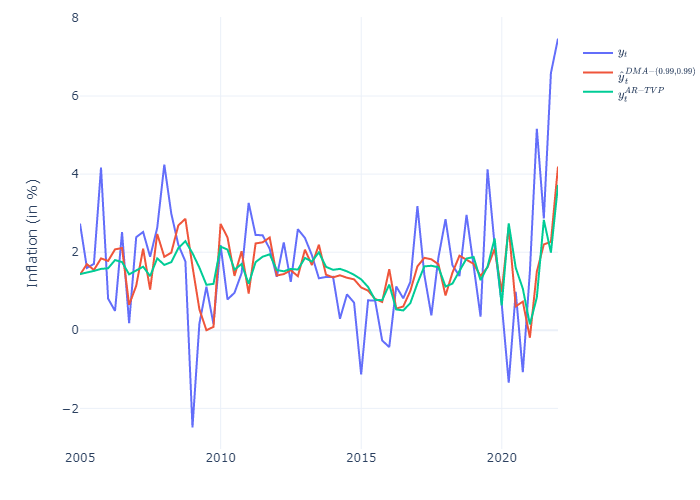

In [29]:
y_preds = pd.concat((dma_fa_h1_1.y_dep,
                     dma_fa_h1_1.y_t_DMA,
                     #dma_fa_h1_1.y_t_DMS,
                     ar_h1_tvp.y_tvp[1:]), axis=1)*100
y_preds = y_preds.loc[dma_fa_h4_1.first_sample_ends:, :]
y_preds.columns = [r'$y_t$',
                r'$\hat{y}_t^{DMA - (0.99, 0.99)}$',
                #r'$\hat{y}_t^{DMS - (0.99, 0.99)}$',
                r'$y_t^{AR-TVP}$']
fig = px.line(y_preds,
              x=y_preds.index,
              y=y_preds.columns)
fig.update_layout(
    title="",
    title_x=0.5,
    yaxis_title='Inflation (in %)',
    xaxis_title='',
    legend_title="",
    margin_b=10,
    margin_t=10,
    legend_orientation='v',
    legend_y=0.95
    )
fig.show()

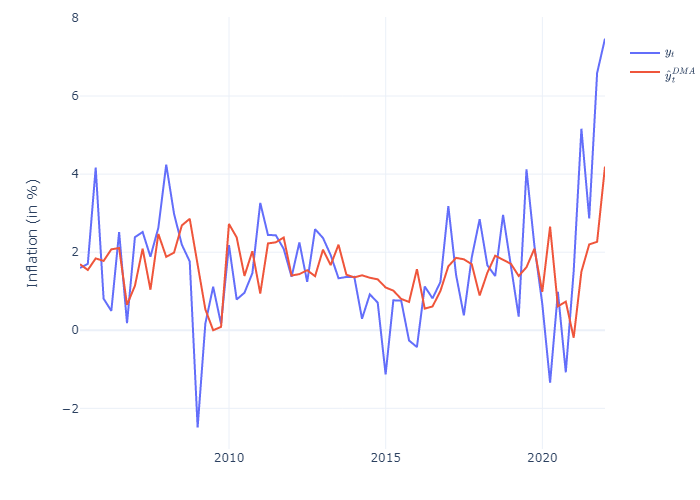

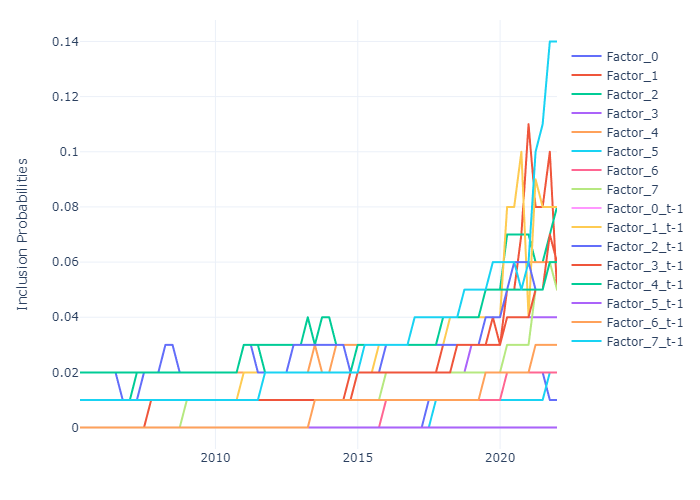

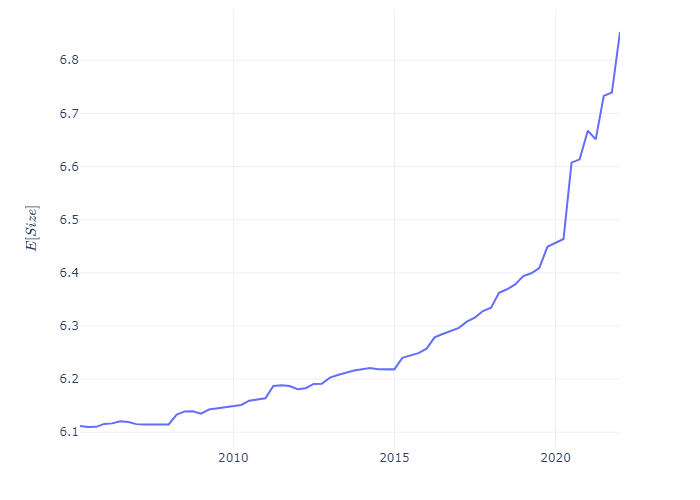

In [30]:
if replicate['preferred_models_analysis']:
    fig = dma_fa_h1_1.forecast_statistics(unit='percent', plot_y_fe=True, return_fig=True, print_stats=False)
    fig.show()
    # plot inclusion probabilities
    fig = dma_fa_h1_1.plot_inclusion_prob(seperate_plots=False, return_fig=True)
    fig.show()
    # plot E[size]
    fig = dma_fa_h1_1.calc_E_size(out='plot', return_fig=True)
    fig.show()

    # # show how important the model without extra factors is
    # # find index of model that contains only the restricted variables
    # z = [1 if np.array_equal(m, np.array([0,1,2,3,4,5])) else 0 for m in dma_fa_h1_1.models]
    # ind = np.nonzero(z)
    # inc_prob_ar = dma_fa_h1_1.prob_pred[:, ind].flatten()
    # print(f'Inclusion probability for AR(p) model: mean {inc_prob_ar.mean()} - median {np.median(inc_prob_ar)}')

## h=4

### DM test

In [31]:
# compare with simple ar
dm_stats_h4 = stats_pd_all_h4.copy()
actual_vals = (dma_fa_h4_1.y_dep[dma_fa_h4_1.first_sample_ends:]).tolist()
prediction_ar_tvp = (ar_h4_tvp.y_tvp[dma_fa_h4_1.first_sample_ends:]).tolist()
# to compare with
prediction_dma_1 = (dma_fa_h4_1.y_t_DMA[dma_fa_h4_1.first_sample_ends:]).tolist()
prediction_dma_2 = dma_fa_h4_2.y_t_DMA[dma_fa_h4_1.first_sample_ends:].tolist()
prediction_dma_3 = dma_fa_h4_3.y_t_DMA[dma_fa_h4_1.first_sample_ends:].tolist()
prediction_dms_1 = dma_fa_h4_1.y_t_DMS[dma_fa_h4_1.first_sample_ends:].tolist()
prediction_dms_2 = dma_fa_h4_2.y_t_DMS[dma_fa_h4_1.first_sample_ends:].tolist()
prediction_dms_3 = dma_fa_h4_3.y_t_DMS[dma_fa_h4_1.first_sample_ends:].tolist()
prediction_tvp = tvp_h4.y_tvp[dma_fa_h4_1.first_sample_ends:].tolist()
prediction_ar = ar_h4.y_tvp[dma_fa_h4_1.first_sample_ends:].tolist()

pred_dict = {#'prediction_dma_1': prediction_dma_1,
             'prediction_dma_2': prediction_dma_2,
             'prediction_dma_3': prediction_dma_3,
             'prediction_dms_1': prediction_dms_1,
             'prediction_dms_2': prediction_dms_2,
             'prediction_dms_3': prediction_dms_3,
             'prediction_tvp': prediction_tvp,
             'prediction_ar_tvp': prediction_ar_tvp,
             'prediction_ar': prediction_ar}
dm_stats_h4.index = ['prediction_dma_1', 'prediction_dma_2', 'prediction_dma_3',
                     'prediction_dms_1', 'prediction_dms_2', 'prediction_dms_3',
                     'prediction_tvp', 'prediction_ar_tvp', 'prediction_ar']


In [32]:
MAD_res_MAFE = []
MAD_res_MSE = []
MAD_res_MAFE.append(1)
MAD_res_MSE.append(1)
for pred in pred_dict.keys():
    # print(pred)
    MAD_res_MAFE.append(dm_test.dm_test(actual_vals, pred_dict[pred], prediction_dma_1, crit='MAD', h=4,power=1)[1])
    MAD_res_MSE.append(dm_test.dm_test(actual_vals, pred_dict[pred], prediction_dma_1, crit='MSE', h=4,power=1)[1])
dm_stats_h4.MAFE = MAD_res_MAFE
dm_stats_h4.MSFE = MAD_res_MSE
dm_stats_h4[['MAFE', 'MSFE']].round(2)

,MAFE,MSFE
prediction_dma_1,1.00,1.00
prediction_dma_2,0.48,0.29
prediction_dma_3,0.41,0.27
prediction_dms_1,0.80,0.44
prediction_dms_2,0.06,0.95
prediction_dms_3,0.00,0.04
prediction_tvp,0.03,0.02
prediction_ar_tvp,0.12,0.15
prediction_ar,0.30,0.58


In [33]:
print(pd.concat((dm_stats_h1[['MAFE', 'MSFE']], dm_stats_h4[['MAFE', 'MSFE']]), axis=1).round(2).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  MAFE &  MSFE &  MAFE &  MSFE \\
\midrule
prediction\_dma\_1  &  0.20 &  0.11 &  1.00 &  1.00 \\
prediction\_dma\_2  &  0.86 &  0.93 &  0.48 &  0.29 \\
prediction\_dma\_3  &  0.44 &  0.31 &  0.41 &  0.27 \\
prediction\_dms\_1  &  0.18 &  0.11 &  0.80 &  0.44 \\
prediction\_dms\_2  &  0.77 &  0.89 &  0.06 &  0.95 \\
prediction\_dms\_3  &  0.74 &  0.48 &  0.00 &  0.04 \\
prediction\_tvp    &  0.01 &  0.05 &  0.03 &  0.02 \\
prediction\_ar\_tvp &  0.42 &  0.67 &  0.12 &  0.15 \\
prediction\_ar     &  1.00 &  1.00 &  0.30 &  0.58 \\
\bottomrule
\end{tabular}



### plots

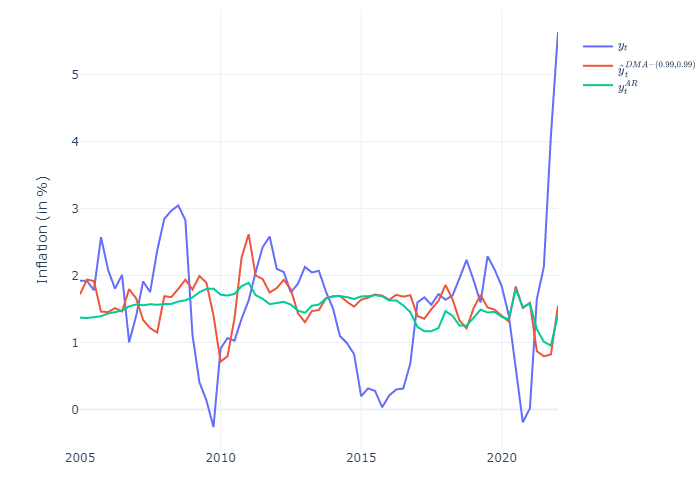

In [34]:
y_preds = pd.concat((dma_fa_h4_1.y_dep,
                     dma_fa_h4_1.y_t_DMA,
                     # dma_fa_h4_3.y_t_DMA,
                     #dma_fa_h4_1.y_t_DMS,
                     ar_h4.y_tvp), axis=1)*100
y_preds = y_preds[dma_fa_h4_1.first_sample_ends:]
y_preds.columns = [r'$y_t$',
                r'$\hat{y}_t^{DMA - (0.99, 0.99)}$',
                   # r'$\hat{y}_t^{DMA - (0.95, 0.95)}$',
                #r'$\hat{y}_t^{DMS - (0.99, 0.99)}$',
                r'$y_t^{AR}$']
fig = px.line(y_preds,
              x=y_preds.index,
              y=y_preds.columns)
fig.update_layout(
    title="",
    title_x=0.5,
    yaxis_title='Inflation (in %)',
    xaxis_title='',
    legend_title="",
    margin_b=10,
    margin_t=10,
    legend_orientation='v',
    legend_y=0.95
    )
fig.show()

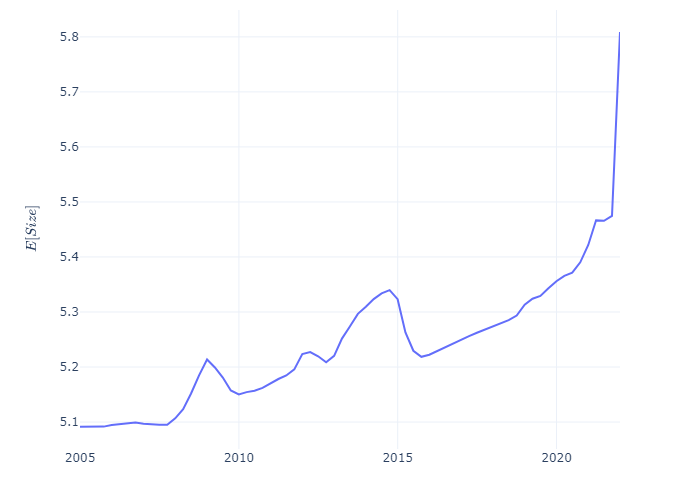

In [35]:
dma_fa_h4_1.calc_E_size(out='plot', return_fig=True)
first_sample_ends = dma_fa_h4_1.first_sample_ends
exp_size = dma_fa_h4_1.exp_size
n = np.where(exp_size.index == first_sample_ends)[0][0]
fig = px.line(x=exp_size.index[n:], y=exp_size[n:]-1,
                          title='Average number of predictors used in DMA')
fig.update_layout(
    title="",
    title_x=0.5,
    yaxis_title=r'$E[Size]$',
    xaxis_title='',
    legend_title="",
    margin_b=10,
    margin_t=10
)

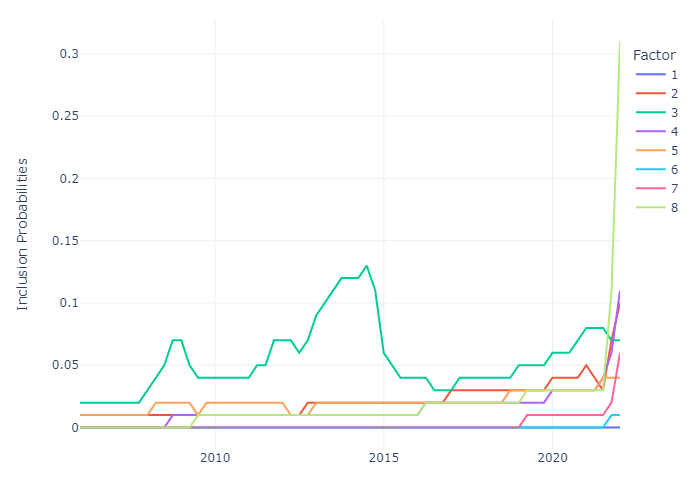

In [36]:
if replicate['preferred_models_analysis']:
    # fig = dma_fa_h4_1.forecast_statistics(unit='percent', plot_y_fe=True, return_fig=True, print_stats=False)
    # fig.show()
    # plot inclusion probabilities
    fig = dma_fa_h4_1.plot_inclusion_prob(seperate_plots=False, return_fig=True,
                                          plot_vars=['Factor_0', 'Factor_1', 'Factor_2',
                                                     'Factor_3', 'Factor_4', 'Factor_5',
                                                     'Factor_6', 'Factor_7'])
    fig.update_layout(
                legend_title="Factor",
    )
    newnames = {'Factor_0':'1',
                'Factor_1':'2',
                'Factor_2':'3',
                'Factor_3':'4',
                'Factor_4':'5',
                'Factor_5':'6',
                'Factor_6':'7',
                'Factor_7':'8'}
    fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
    fig.show()
    # plot E[size]
    # fig = dma_fa_h4_1.calc_E_size(out='plot', return_fig=True)
    # fig.show()

    # # show how important the model without extra factors is
    # # find index of model that contains only the restricted variables
    # z = [1 if np.array_equal(m, np.array([0,1,2,3,4,5])) else 0 for m in dma_fa_h4_1.models]
    # ind = np.nonzero(z)
    # inc_prob_ar = dma_fa_h4_1.prob_pred[:, ind].flatten()
    # print(f'Inclusion probability for AR(p) model: mean {inc_prob_ar.mean()} - median {np.median(inc_prob_ar)}')

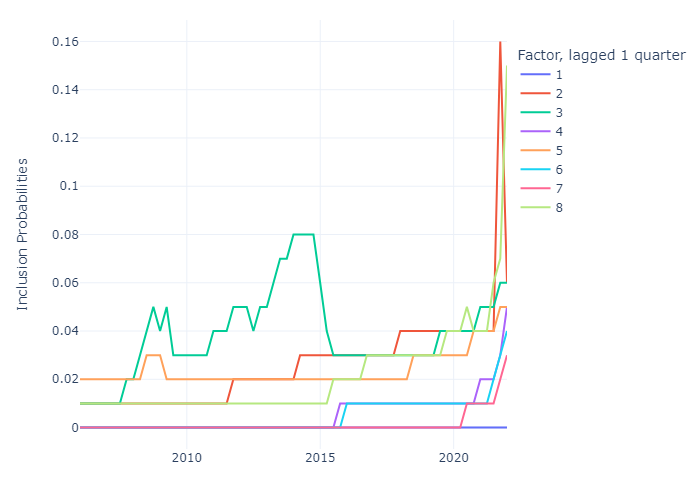

In [37]:
if replicate['preferred_models_analysis']:
    fig = dma_fa_h4_1.plot_inclusion_prob(seperate_plots=False, return_fig=True,
                                          plot_vars=['Factor_0_t-1', 'Factor_1_t-1', 'Factor_2_t-1',
                                                     'Factor_3_t-1', 'Factor_4_t-1', 'Factor_5_t-1',
                                                     'Factor_6_t-1', 'Factor_7_t-1'])
    fig.update_layout(
                legend_title="Factor, lagged 1 quarter",
    )
    newnames = {'Factor_0_t-1':'1',
                'Factor_1_t-1':'2',
                'Factor_2_t-1':'3',
                'Factor_3_t-1':'4',
                'Factor_4_t-1':'5',
                'Factor_5_t-1':'6',
                'Factor_6_t-1':'7',
                'Factor_7_t-1':'8'}
    fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
    fig.show()

In [38]:
dma_fa_h4_1.models
best_model_ind = np.argmax(dma_fa_h4_1.prob_pred, axis=1)
# np.array([dma_fa_h4_1.prob_pred[i, item] for i, item in enumerate(best_model_ind)])
np.array([dma_fa_h4_1.models[item] for i, item in enumerate(best_model_ind)])

C:\Users\yanni\AppData\Local\Temp/ipykernel_8756/1996847950.py:4: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



array([array([0, 1, 2, 3, 4, 5, 6]), array([0, 1, 2, 3, 4, 5]),
       array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]),
       array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]),
       array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]),
       array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]),
       array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]),
       array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]),
       array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]),
       array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]),
       array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]),
       array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]),
       array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]),
       array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]),
       array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]),
       array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]),
       array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]),
       array([0, 1, 2

# DMA and Factor Analysis interaction
## DMA with no FA + comparison

In [39]:
if not replicate['DMA_FA_interaction']: # stop running from here
    raise Exception('Stop because DMA_FA_interaction = False')

In [42]:
params.use_x = ['unemp',    # or employment
                'GDP',
                # 'prod_ind', # or prod_constr (might be better for h=4)
                'interest_rate_short',
                # 'interest_rate_long',
                # 'dax',
                'M3',
                'infl_exp_next_year', # 'infl_exp_current_year'
                # 'trade_exp',
                'CPI_house_energy',  # or PCI_energy_ or HICP_energy
                # 'supply_index_global',  # or 'supply_index_eu'
                'business_situation'
                ]
params.miss_treatment = 1
params.hlag = 1
params.tcodesX = params.get_tcodesX(selection)
# params.h_fore=1
# data_h1 = Data(df_sa, params)
params.h_fore=4
data_h4 = Data(df_sa, params)
dma_h4_1, stats_h4_1 = DMA_steps(params, data_h4, 0.99, 0.99, False, 'dma_h4_1', output_path)
dma_h4_2, stats_h4_2 = DMA_steps(params, data_h4, 0.99, 0.99, False, 'dma_h4_2', output_path)
dma_h4_3, stats_h4_3 = DMA_steps(params, data_h4, 0.99, 0.99, False, 'dma_h4_3', output_path)

(alpha, lambda) = (0.99, 0.99)


100%|██████████| 114/114 [00:33<00:00,  3.42it/s]


DMA finished
(alpha, lambda) = (0.99, 0.99)


100%|██████████| 114/114 [00:32<00:00,  3.49it/s]


DMA finished
(alpha, lambda) = (0.99, 0.99)


100%|██████████| 114/114 [00:30<00:00,  3.75it/s]

DMA finished


In [43]:
stats2 = ['MAFE', 'MSFE', 'BIAS']
stats_pd_no_fa_h4 = pd.DataFrame.from_dict(data={'DMA, h=4, (0.99, 0.99)': stats_h4_1[2:5],
                                            'DMA, h=4, (0.97, 0.97)': stats_h4_2[2:5],
                                            'DMA, h=4, (0.95, 0.95)': stats_h4_3[2:5],
                                            'DMS, h=4, (0.99, 0.99)': stats_h4_1[5:],
                                            'DMS, h=4, (0.97, 0.97)': stats_h4_2[5:],
                                            'DMS, h=4, (0.95, 0.95)': stats_h4_3[5:],

                                               },
                                orient='index',
                                columns=stats2)
stats_pd_no_fa_h4*[100, 100**2, 100]

,MAFE,MSFE,BIAS
"DMA, h=4, (0.99, 0.99)",0.482969,0.719141,0.048530
"DMA, h=4, (0.97, 0.97)",0.482969,0.719141,0.048530
"DMA, h=4, (0.95, 0.95)",0.482969,0.719141,0.048530
"DMS, h=4, (0.99, 0.99)",0.464157,0.718050,0.034854
"DMS, h=4, (0.97, 0.97)",0.464157,0.718050,0.034854
"DMS, h=4, (0.95, 0.95)",0.464157,0.718050,0.034854


In [44]:
print((stats_pd_no_fa_h4*[100, 100**2, 100]).round(4).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &    MAFE &    MSFE &    BIAS \\
\midrule
DMA, h=4, (0.99, 0.99) &  0.4830 &  0.7191 &  0.0485 \\
DMA, h=4, (0.97, 0.97) &  0.4830 &  0.7191 &  0.0485 \\
DMA, h=4, (0.95, 0.95) &  0.4830 &  0.7191 &  0.0485 \\
DMS, h=4, (0.99, 0.99) &  0.4642 &  0.7181 &  0.0349 \\
DMS, h=4, (0.97, 0.97) &  0.4642 &  0.7181 &  0.0349 \\
DMS, h=4, (0.95, 0.95) &  0.4642 &  0.7181 &  0.0349 \\
\bottomrule
\end{tabular}



In [45]:
dm_stats_h4 = stats_pd_no_fa_h4.copy()
actual_vals = (dma_h4_1.y_dep[dma_h4_1.first_sample_ends:]).tolist()
comparison = (dma_fa_h4_1.y_t_DMA[dma_h4_1.first_sample_ends:]).tolist()

prediction_dma_1= (dma_h4_1.y_t_DMA[dma_h4_1.first_sample_ends:]).tolist()
prediction_dma_2 = (dma_h4_1.y_t_DMA[dma_h4_1.first_sample_ends:]).tolist()
prediction_dma_3 = (dma_h4_1.y_t_DMA[dma_h4_1.first_sample_ends:]).tolist()
prediction_dms_1 = (dma_h4_1.y_t_DMS[dma_h4_1.first_sample_ends:]).tolist()
prediction_dms_2 = (dma_h4_1.y_t_DMS[dma_h4_1.first_sample_ends:]).tolist()
prediction_dms_3 = (dma_h4_1.y_t_DMS[dma_h4_1.first_sample_ends:]).tolist()


pred_dict = {'prediction_dma_1 ': prediction_dma_1,
             'prediction_dma_2 ': prediction_dma_2,
             'prediction_dma_3 ': prediction_dma_3,
             'prediction_dms_1': prediction_dms_1,
             'prediction_dms_2': prediction_dms_2,
             'prediction_dms_3': prediction_dms_3}

dm_stats_h4.index = ['prediction_dma_1', 'prediction_dma_2', 'prediction_dma_3',
                     'prediction_dms_1', 'prediction_dms_2', 'prediction_dms_3']

In [46]:
MAD_res_MAFE = []
MAD_res_MSE = []
for pred in pred_dict.keys():
    # print(pred)
    MAD_res_MAFE.append(dm_test.dm_test(actual_vals, pred_dict[pred], comparison, crit='MAD', h=1,power=1)[1])
    MAD_res_MSE.append(dm_test.dm_test(actual_vals, pred_dict[pred], comparison, crit='MSE', h=1,power=1)[1])
dm_stats_h4.MAFE = MAD_res_MAFE
dm_stats_h4.MSFE = MAD_res_MSE
dm_stats_h4[['MAFE', 'MSFE']]

,MAFE,MSFE
prediction_dma_1,0.031066,0.056838
prediction_dma_2,0.031066,0.056838
prediction_dma_3,0.031066,0.056838
prediction_dms_1,0.337860,0.277517
prediction_dms_2,0.337860,0.277517
prediction_dms_3,0.337860,0.277517


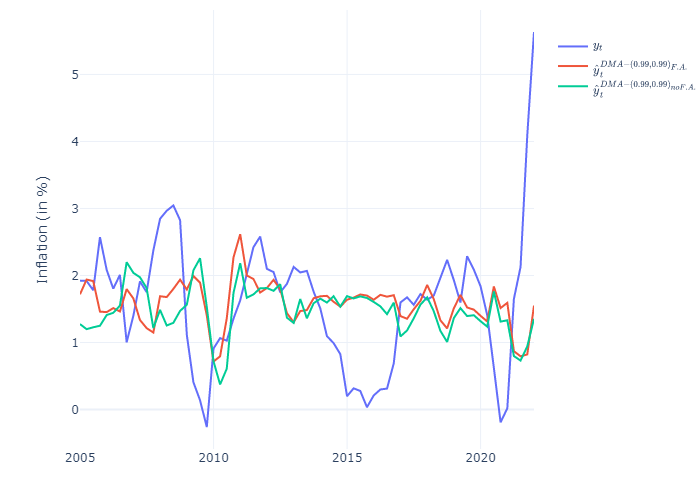

In [47]:
y_preds = pd.concat((dma_fa_h4_1.y_dep,
                     dma_fa_h4_1.y_t_DMA,
                     dma_h4_1.y_t_DMA), axis=1)*100
y_preds = y_preds[dma_fa_h4_1.first_sample_ends:]
y_preds.columns = [r'$y_t$',
                r'$\hat{y}_t^{DMA - (0.99, 0.99)_{F.A.}}$',
                r'$\hat{y}_t^{DMA - (0.99, 0.99)_{no F.A.}}$']
fig = px.line(y_preds,
              x=y_preds.index,
              y=y_preds.columns)
fig.update_layout(
    title="",
    title_x=0.5,
    yaxis_title='Inflation (in %)',
    xaxis_title='',
    legend_title="",
    margin_b=10,
    margin_t=10,
    legend_orientation='v',
    legend_y=0.95
    )
fig.show()

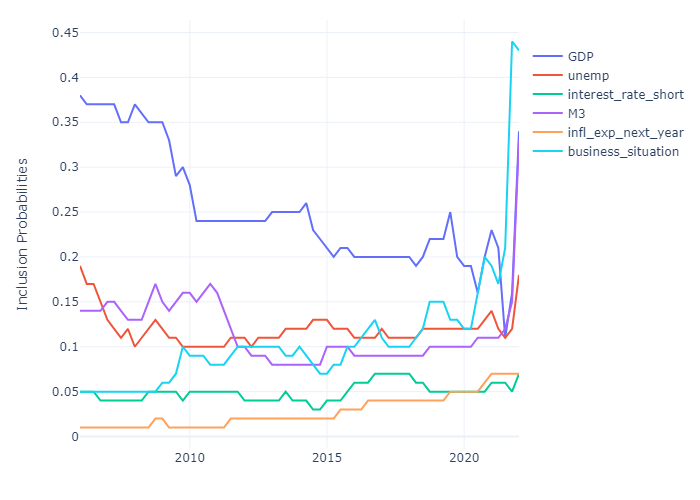

In [48]:
if replicate['preferred_models_analysis']:
    # fig = dma_fa_h4_1.forecast_statistics(unit='percent', plot_y_fe=True, return_fig=True, print_stats=False)
    # fig.show()
    # plot inclusion probabilities
    fig = dma_h4_1.plot_inclusion_prob(seperate_plots=False, return_fig=True,
                                          plot_vars=['GDP', 'unemp', 'interest_rate_short', 'M3', 'infl_exp_next_year', 'business_situation'# , 'CPI_house_energy'
                                                     ]
                                          )

    fig.show()
    # plot E[size]
    # fig = dma_fa_h4_1.calc_E_size(out='plot', return_fig=True)
    # fig.show()

    # # show how important the model without extra factors is
    # # find index of model that contains only the restricted variables
    # z = [1 if np.array_equal(m, np.array([0,1,2,3,4,5])) else 0 for m in dma_h4_1.models]
    # ind = np.nonzero(z)
    # inc_prob_ar = dma_h4_1.prob_pred[:, ind].flatten()
    # print(f'Inclusion probability for AR(p) model: mean {inc_prob_ar.mean()} - median {np.median(inc_prob_ar)}')

## DMA on differnt lag n_factor combinations

In [49]:
# create datasets for different factor lag combinations
# 0 lags
fa_lags_1 = 0
df_fa = df_sa_trans.drop(infl_vars, axis=1)
n_factors = 16
fa = FactorAnalyzer(n_factors=n_factors, rotation='oblimax')    # quartimax for orthogonal rotation, oblimax for oblique
fa.fit(df_fa)
df_factors = pd.DataFrame(fa.transform(df_fa.fillna(0)), index = df_fa.index)
# rename columns
factor_cols = ['Factor_'+str(i) for i in list(df_factors.columns)]
df_factors.columns = factor_cols
df_fa_post_0_lags = pd.concat((df_intercept_CPI, df_factors), axis=1)

# 1 lag
fa_lags_2 = 1
df_fa = df_sa_trans.drop(infl_vars, axis=1)
n_factors = 8
fa = FactorAnalyzer(n_factors=n_factors, rotation='oblimax')    # quartimax for orthogonal rotation, oblimax for oblique
fa.fit(df_fa)
df_factors = pd.DataFrame(fa.transform(df_fa.fillna(0)), index = df_fa.index)
# rename columns
factor_cols = ['Factor_'+str(i) for i in list(df_factors.columns)]
df_factors.columns = factor_cols
df_factors_with_lag = pd.concat((df_factors, df_factors.shift(1)), axis=1)
factor_cols_lag1 = [i+'_t-1' for i in factor_cols]
df_factors_with_lag.columns = factor_cols+factor_cols_lag1
df_fa_post_1_lag = pd.concat((df_intercept_CPI, df_factors_with_lag), axis=1)
df_fa_post_1_lag = df_fa_post_1_lag.iloc[fa_lags_2:, :]

# 2 lags
fa_lags_2 = 3
df_fa = df_sa_trans.drop(infl_vars, axis=1)
n_factors = 4
fa = FactorAnalyzer(n_factors=n_factors, rotation='oblimax')    # quartimax for orthogonal rotation, oblimax for oblique
fa.fit(df_fa)
df_factors = pd.DataFrame(fa.transform(df_fa.fillna(0)), index = df_fa.index)
# rename columns
factor_cols = ['Factor_'+str(i) for i in list(df_factors.columns)]
df_factors.columns = factor_cols
df_factors_with_lag = pd.concat((df_factors, df_factors.shift(1), df_factors.shift(2), df_factors.shift(3)), axis=1)
factor_cols_lag1 = [i+'_t-1' for i in factor_cols]
factor_cols_lag2 = [i+'_t-2' for i in factor_cols]
factor_cols_lag3 = [i+'_t-3' for i in factor_cols]
df_factors_with_lag.columns = factor_cols+factor_cols_lag1+factor_cols_lag2+factor_cols_lag3
df_fa_post_3_lags = pd.concat((df_intercept_CPI, df_factors_with_lag), axis=1)
df_fa_post_3_lags = df_fa_post_3_lags.iloc[fa_lags_2:, :]

stats_fe = ['alpha', 'lambda', 'MAFE_DMA', 'MSFE_DMA', 'BIAS_DMA', 'MAFE_DMS', 'MSFE_DMS', 'BIAS_DMS']

In [50]:
# create instances of data classes
params.h_fore = 4

data_fa_h4_0_lags = Data(df_sa, params)
data_fa_h4_0_lags.X = df_fa_post_0_lags
data_fa_h4_0_lags.T = data_fa_h4_0_lags.X.shape[0]
data_fa_h4_0_lags.N = data_fa_h4_0_lags.X.shape[1]

data_fa_h4_1_lags = Data(df_sa, params)
data_fa_h4_1_lags.X = df_fa_post_1_lag
data_fa_h4_1_lags.T = data_fa_h4_1_lags.X.shape[0]
data_fa_h4_1_lags.N = data_fa_h4_1_lags.X.shape[1]
data_fa_h4_1_lags.y_dep = data_fa_h4_1_lags.y_dep[fa_lags_1+1:]    # adjust for lagging

data_fa_h4_3_lags = Data(df_sa, params)
data_fa_h4_3_lags.X = df_fa_post_3_lags
data_fa_h4_3_lags.T = data_fa_h4_3_lags.X.shape[0]
data_fa_h4_3_lags.N = data_fa_h4_3_lags.X.shape[1]
data_fa_h4_3_lags.y_dep = data_fa_h4_3_lags.y_dep[fa_lags_2:]    # adjust for lagging

In [56]:
# run DMA
dma_fa_h1_0_lags, stats_fa_h1_0_lags = DMA_steps(params, data_fa_h4_0_lags, 0.99, 0.99, False, 'dma_fa_h1_0_lags', output_path)
dma_fa_h1_1_lags, stats_fa_h1_1_lags = DMA_steps(params, data_fa_h4_1_lags, 0.99, 0.99, False, 'dma_fa_h1_0_lags', output_path)
dma_fa_h1_3_lags, stats_fa_h1_3_lags = DMA_steps(params, data_fa_h4_3_lags, 0.99, 0.99, False, 'dma_fa_h1_0_lags', output_path)

(alpha, lambda) = (0.99, 0.99)


100%|██████████| 114/114 [09:14<00:00,  4.86s/it]


DMA finished
(alpha, lambda) = (0.99, 0.99)


100%|██████████| 113/113 [08:07<00:00,  4.31s/it]


DMA finished
(alpha, lambda) = (0.99, 0.99)


100%|██████████| 111/111 [09:42<00:00,  5.25s/it]


DMA finished


In [57]:
# print results
stats2 = ['MAFE', 'MSFE', 'BIAS']
stats_pd_diff_lags_h4 = pd.DataFrame.from_dict(data={'DMA F.A., h=4, 0 lags, (0.99, 0.99)': stats_fa_h1_0_lags[2:5],
                                            'DMA F.A., h=4, 1 lags, (0.99, 0.99)': stats_fa_h1_1_lags[2:5],
                                               'DMA F.A., h=4, 4 lags, (0.99, 0.99)': stats_fa_h1_3_lags[2:5],
                                               'DMS F.A., h=4, 0 lags, (0.99, 0.99)': stats_fa_h1_0_lags[5:],
                                            'DMS F.A., h=4, 1 lags, (0.99, 0.99)': stats_fa_h1_1_lags[5:],
                                               'DMS F.A., h=4, 4 lags, (0.99, 0.99)': stats_fa_h1_3_lags[5:]},
                                orient='index',
                                columns=stats2)
stats_pd_diff_lags_h4*[100, 100**2, 100]

,MAFE,MSFE,BIAS
"DMA F.A., h=4, 0 lags, (0.99, 0.99)",0.458809,0.663330,0.003420
"DMA F.A., h=4, 1 lags, (0.99, 0.99)",0.465304,0.683692,0.007338
"DMA F.A., h=4, 4 lags, (0.99, 0.99)",0.474190,0.696883,0.008257
"DMS F.A., h=4, 0 lags, (0.99, 0.99)",0.457256,0.662490,0.002561
"DMS F.A., h=4, 1 lags, (0.99, 0.99)",0.463090,0.666844,0.005739
"DMS F.A., h=4, 4 lags, (0.99, 0.99)",0.474825,0.682639,0.012590


In [58]:
# run DM test
dm_stats_h4 = stats_pd_diff_lags_h4.copy()
actual_vals = (dma_fa_h1_0_lags.y_dep[dma_fa_h1_0_lags.first_sample_ends:]).tolist()
prediction_dma_0_lags = (dma_fa_h1_0_lags.y_t_DMA[dma_fa_h1_0_lags.first_sample_ends:]).tolist()
prediction_dma_1_lags = dma_fa_h1_1_lags.y_t_DMA[dma_fa_h1_0_lags.first_sample_ends:].tolist()
prediction_dma_3_lags = dma_fa_h1_3_lags.y_t_DMA[dma_fa_h1_0_lags.first_sample_ends:].tolist()
prediction_dms_0_lags = (dma_fa_h1_0_lags.y_t_DMS[dma_fa_h1_0_lags.first_sample_ends:]).tolist()
prediction_dms_1_lags = dma_fa_h1_1_lags.y_t_DMS[dma_fa_h1_0_lags.first_sample_ends:].tolist()
prediction_dms_3_lags = dma_fa_h1_3_lags.y_t_DMS[dma_fa_h1_0_lags.first_sample_ends:].tolist()


pred_dict = {'prediction_dma_0_lags ': prediction_dma_0_lags ,
             'prediction_dma_1_lags ': prediction_dma_1_lags ,
             'prediction_dma_3_lags ': prediction_dma_3_lags ,
             'prediction_dms_0_lags': prediction_dms_0_lags,
             'prediction_dms_1_lags': prediction_dms_1_lags,
             'prediction_dms_3_lags': prediction_dms_3_lags}

dm_stats_h4.index = ['prediction_dma_0_lags', 'prediction_dma_1_lags', 'prediction_dma_3_lags',
                     'prediction_dms_0_lags', 'prediction_dms_1_lags', 'prediction_dms_3_lags']
MAD_res_MAFE = []
MAD_res_MSE = []
for pred in pred_dict.keys():
    print(pred)
    if pred == 'prediction_dms_0_lags':
        MAD_res_MAFE.append(1)
        MAD_res_MSE.append(1)
    else:
        MAD_res_MAFE.append(dm_test.dm_test(actual_vals, pred_dict[pred], prediction_dms_0_lags, crit='MAD', h=1,power=1)[1])
        MAD_res_MSE.append(dm_test.dm_test(actual_vals, pred_dict[pred], prediction_dms_0_lags, crit='MSE', h=1,power=1)[1])
dm_stats_h4.MAFE = MAD_res_MAFE
dm_stats_h4.MSFE = MAD_res_MSE
dm_stats_h4[['MAFE', 'MSFE']]

prediction_dma_0_lags 
prediction_dma_1_lags 
prediction_dma_3_lags 
prediction_dms_0_lags
prediction_dms_1_lags
prediction_dms_3_lags


,MAFE,MSFE
prediction_dma_0_lags,0.070740,0.751303
prediction_dma_1_lags,0.407958,0.248606
prediction_dma_3_lags,0.730108,0.223686
prediction_dms_0_lags,1.000000,1.000000
prediction_dms_1_lags,0.886024,0.839864
prediction_dms_3_lags,0.644572,0.897286


## regression of inflation on all factors

In [59]:
# Init factor analysis object
df_fa = df_sa_trans.drop(infl_vars, axis=1)
n_factors = df_fa.shape[1]
fa = FactorAnalyzer(n_factors=n_factors, rotation='oblimax')    # quartimax for orthogonal rotation, oblimax for oblique
fa.fit(df_fa)
df_factors = pd.DataFrame(fa.transform(df_fa.fillna(0)), index = df_fa.index)

In [60]:
#pd_factor_rsqaured = pd.DataFrame(columns=df_factors.columns)
rsquared = {}
for name, values in df_factors.iteritems():
    df_temp = pd.concat((df_sa.CPI, values), axis=1).dropna()
    model = OLS(endog=df_temp.iloc[:,0], exog=values).fit()
    rsquared[name] = model.rsquared
pd.Series(rsquared, index=df_factors.columns)

0     0.079837
1     0.153182
2     0.077178
3     0.427711
4     0.137743
5     0.186377
6     0.210837
7     0.107773
8     0.142989
9     0.130320
10    0.143593
11    0.196600
12    0.051937
13    0.005309
14    0.202288
15    0.197264
16    0.106508
17    0.206782
18    0.000032
19    0.047204
20    0.000222
21    0.203266
22    0.209117
23    0.143053
24    0.183812
25    0.202385
26    0.203188
27    0.177442
28    0.150588
29    0.147802
30    0.211602
31    0.162739
32    0.167927
33    0.204440
34    0.000000
dtype: float64

In [61]:
factors_R2 = pd.Series(rsquared, index=df_factors.columns)
factors_best = []
factors_R2_temp = factors_R2.copy()
for i in range(8):
    ind = np.argmax(factors_R2_temp)
    print(ind)
    factors_best.append(ind)
    factors_R2_temp.pop(ind)
factors_best

3
29
28
27
26
25
24
23


[3, 29, 28, 27, 26, 25, 24, 23]

In [62]:
# rename columns
factor_cols = ['Factor_'+str(i) for i in list(df_factors.columns)]
df_factors.columns = factor_cols
df_factors_with_lag = pd.concat((df_factors, df_factors.shift(1)), axis=1)
factor_cols_lag1 = [i+'_t-1' for i in factor_cols]
df_factors_with_lag.columns = factor_cols+factor_cols_lag1
df_fa_post_best = pd.concat((df_intercept_CPI, df_factors_with_lag), axis=1)
df_fa_post_best = df_fa_post_best.iloc[fa_lags_1+1:, :]

In [64]:
data_fa_h4_best = Data(df_sa, params)
data_fa_h4_best.X = df_fa_post_best
data_fa_h4_best.T = data_fa_h4_best.X.shape[0]
data_fa_h4_best.N = data_fa_h4_best.X.shape[1]
data_fa_h4_best.y_dep = data_fa_h4_best.y_dep[fa_lags_1+1:]    # adjust for lagging
dma_fa_h4_best, stats_fa_h4_best = DMA_steps(params, data_fa_h4_best, 0.99, 0.99, False, 'dma_fa_h4_best', None)

(alpha, lambda) = (0.99, 0.99)


KeyboardInterrupt: 

In [ ]:
stats2 = ['MAFE', 'MSFE', 'BIAS']
stats_pd_best_facts = pd.DataFrame.from_dict(data={'DMA, h=4, 1 lag, (0.99, 0.99)': stats_fa_h4_best[2:5],
                                                   'DMS, h=4, 1 lag, (0.99, 0.99)': stats_fa_h4_best[5:]},
                                orient='index',
                                columns=stats2)
stats_pd_best_facts*[100, 100**2, 100]